<a href="https://colab.research.google.com/github/rikdantas/Aprendizagem-de-Maquinas/blob/main/IMD1101/Pratica_04/Pratica04_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prática 04 - Técnica Supervisionada (MLP)
Nesse notebook será aplicado o método de MLP nas 6 melhores bases que eu tinha encontrado na prática 01 e também nas 6 bases que foram aplicados o PCA também na prática 01.

Aluno: Paulo Ricardo Dantas

In [1]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import gdown
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, StratifiedKFold

## Baixando os datasets

In [2]:
# Criando função para baixar os datasets, assim deixando o código um pouco mais organizado
def baixar_dataset(url, output):
    gdown.download(url, output, quiet=True)

In [3]:
# Baixando datasets do VGG16
baixar_dataset('https://drive.google.com/uc?id=1Lig0-UqpGvMQCmV5r5U__yucoocrlbtf', 'VGG16_1.csv')
baixar_dataset('https://drive.google.com/uc?id=1V7_N11eqBnTiM9iKY3vhMVrTzoERrijS', 'VGG16_2.csv')
baixar_dataset('https://drive.google.com/uc?id=1d8spY-o4xBsozdeSbGGlweZrips1m0HC', 'VGG16_3.csv')

# Baixando datasets do VGG19
baixar_dataset('https://drive.google.com/uc?id=1yjuqQKxXtBqlMetGgD3fyFjDZ3zg3YDS', 'VGG19_1.csv')
baixar_dataset('https://drive.google.com/uc?id=13nmb2kPrv6oVKlhodM-_ierzsMrvWL18', 'VGG19_2.csv')
baixar_dataset('https://drive.google.com/uc?id=1qB2SQXLtgS01FqTrwGYLdOY1pwRqkuXu', 'VGG19_3.csv')

# Baixando datasets do PCA
baixar_dataset('https://drive.google.com/uc?id=14sGLGGak-1WZwnLrqEMEZbYWNZL1dIVn', 'PCA_1.csv')
baixar_dataset('https://drive.google.com/uc?id=1DCXErsoiqwcM59QkIOdlZcIVGZDmWYTK', 'PCA_2.csv')
baixar_dataset('https://drive.google.com/uc?id=15k9bMm1ZfliNeHQ6MX7SlEy49UQJrxtv', 'PCA_3.csv')
baixar_dataset('https://drive.google.com/uc?id=17BJNdaH_8fCYTJn-l-QH7ayRaLuWYxQ6', 'PCA_4.csv')
baixar_dataset('https://drive.google.com/uc?id=18_qRzZ4wA-laBL0bsCch6xTus7SYLjLf', 'PCA_5.csv')
baixar_dataset('https://drive.google.com/uc?id=1mc9uT_EDkh9xC8rWnZTUZp6qX8Q7verz', 'PCA_6.csv')

## Importando os datasets
Vamos usar o pandas para importar os datasets para DataFrames. Usaremos os mesmos nomes que foram baixados os arquivos dos datasets. Podemos relacionar os datasets com as configurações como visto na tabela a seguir:

| Nome do dataset | Configuração            |
|-----------------|-------------------------|
| VGG16_1         | CNN_VGG16_128_avg       |
| VGG16_2         | CNN_VGG16_128_max       |
| VGG16_3         | CNN_VGG16_256_avg       |
| VGG19_1         | CNN_VGG19_128_avg       |
| VGG19_2         | CNN_VGG19_128_max       |
| VGG19_3         | CNN_VGG19_256_avg       |
| PCA_1           | PCA_CNN_VGG16_128_avg   |
| PCA_2           | PCA_CNN_VGG16_128_max   |
| PCA_3           | PCA_CNN_VGG16_256_avg   |
| PCA_4           | PCA_CNN_VGG19_128_avg   |
| PCA_5           | PCA_CNN_VGG19_128_max   |
| PCA_6           | PCA_CNN_VGG19_256_avg   |


In [4]:
# Importando os datasets do VGG16
vgg16_1 = pd.read_csv('VGG16_1.csv', encoding='utf-8')
vgg16_2 = pd.read_csv('VGG16_2.csv', encoding='utf-8')
vgg16_3 = pd.read_csv('VGG16_3.csv', encoding='utf-8')

# Importando os datasets do VGG19
vgg19_1 = pd.read_csv('VGG19_1.csv', encoding='utf-8')
vgg19_2 = pd.read_csv('VGG19_2.csv', encoding='utf-8')
vgg19_3 = pd.read_csv('VGG19_3.csv', encoding='utf-8')

# Importando os datasets do PCA
pca_1 = pd.read_csv('PCA_1.csv', encoding='utf-8')
pca_2 = pd.read_csv('PCA_2.csv', encoding='utf-8')
pca_3 = pd.read_csv('PCA_3.csv', encoding='utf-8')
pca_4 = pd.read_csv('PCA_4.csv', encoding='utf-8')
pca_5 = pd.read_csv('PCA_5.csv', encoding='utf-8')
pca_6 = pd.read_csv('PCA_6.csv', encoding='utf-8')

## Aplicando o MLP

### Utilizando o holdout

In [5]:
# Lista dos datasets
vgg_datasets = [vgg16_1, vgg16_2, vgg16_3, vgg19_1, vgg19_2, vgg19_3]
pca_datasets = [pca_1, pca_2, pca_3, pca_4, pca_5, pca_6]

# Parâmetros
hidden_vgg = 256
hidden_pca = 6
learning_rates = [0.001, 0.01, 0.1]
iterations = [500, 1000, 1500]

# DataFrame para armazenar os resultados
results = []

#### Criando função para auxiliar na organização do código

In [6]:
# Função para rodar experimentos
def run_experiment(datasets, hidden_neurons, dataset_type):
    for i, dataset in enumerate(datasets):
        X = dataset.iloc[:, :-1]
        y = dataset['class']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

        for lr in learning_rates:
            for iters in iterations:
                # Configurando o MLP
                mlp = MLPClassifier(
                    activation='relu',
                    solver='adam',
                    hidden_layer_sizes=(hidden_neurons,),
                    learning_rate_init=lr,
                    max_iter=iters,
                    random_state=1
                )
                # Treinando e avaliando
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                acc = accuracy_score(y_test, y_pred)

                # Armazenando o resultado
                results.append({
                    'Dataset': f"{dataset_type}_{i+1}",
                    'Hidden Neurons': hidden_neurons,
                    'Learning Rate': lr,
                    'Iterations': iters,
                    'Accuracy': acc
                })

#### Rodando os experimentos

In [ ]:
# Rodando os experimentos para VGG e PCA
run_experiment(vgg_datasets, hidden_vgg, "VGG")
run_experiment(pca_datasets, hidden_pca, "PCA")

# Convertendo resultados em DataFrame
results_holdout = pd.DataFrame(results)

# Salvando os resultados em CSV
results_holdout.to_csv('Resultados_MLP_Holdout.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### Utilizando K-Fold

In [7]:
# Lista dos datasets
vgg_datasets = [vgg16_1, vgg16_2, vgg16_3, vgg19_1, vgg19_2, vgg19_3]
pca_datasets = [pca_1, pca_2, pca_3, pca_4, pca_5, pca_6]

# Parâmetros
hidden_vgg = 256
hidden_pca = 6
learning_rates = [0.001, 0.01, 0.1]
iterations = [500, 1000, 1500]

# DataFrame para armazenar os resultados
results_kfold = []

#### Criando função para auxiliar na organização do código

In [8]:
# Função para rodar experimentos com validação cruzada
def run_experiment_cv(datasets, hidden_neurons, dataset_type):
    for i, dataset in enumerate(datasets):
        X = dataset.iloc[:, :-1]
        y = dataset['class']

        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

        for lr in learning_rates:
            for iters in iterations:
                # Configurando o MLP
                mlp = MLPClassifier(
                    activation='relu',
                    solver='adam',
                    hidden_layer_sizes=(hidden_neurons,),
                    learning_rate_init=lr,
                    max_iter=iters,
                    random_state=1
                )
                # Executando 10-fold CV
                scores = cross_val_score(mlp, X, y, cv=skf, scoring='accuracy')

                # Armazenando o resultado
                results_kfold.append({
                    'Dataset': f"{dataset_type}_{i+1}",
                    'Hidden Neurons': hidden_neurons,
                    'Learning Rate': lr,
                    'Iterations': iters,
                    'Mean Accuracy': np.mean(scores),
                    'Std Dev Accuracy': np.std(scores)
                })

#### Rodando os experimentos

In [ ]:
# Rodando os experimentos para VGG e PCA
run_experiment_cv(vgg_datasets, hidden_vgg, "VGG")
run_experiment_cv(pca_datasets, hidden_pca, "PCA")

# Convertendo resultados em DataFrame
results_kfold_df = pd.DataFrame(results_kfold)

# Salvando os resultados em CSV
results_kfold_df.to_csv('Resultados_MLP_KFold.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

## Extra: Variando a quantidade de neurônios na camada oculta.
Como foi mostrado em sala, existe uma convenção para a escolha da quantidade de neurônios na camada oculta. Porém é interessante visualizar as zonas de underfit e overfit conforme é variado a quantidade de neurônios. Para isso iremos utilizar o modelo que apresentou melhor acurácia, aproveitando que é o PCA e só tem poucos atributos.

### Aplicando o MLP

In [9]:
# Parâmetros
neurons_range = range(2, 11)  # De 2 a 10 neurônios
learning_rate = 0.001
iterations = 1500

# Preparando os dados
X = vgg19_1.iloc[:, :-1]
y = vgg19_1['class']

# Validação cruzada (10-fold)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Armazenar resultados
accuracies = []

for neurons in neurons_range:
    # Configurando o MLP
    mlp = MLPClassifier(
        activation='relu',
        solver='adam',
        hidden_layer_sizes=(neurons,),
        learning_rate_init=learning_rate,
        max_iter=iterations,
        random_state=1
    )
    # Calculando a acurácia média com 10-fold CV
    scores = cross_val_score(mlp, X, y, cv=skf, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    accuracies.append(mean_accuracy)

### Plotando e salvando o gráfico


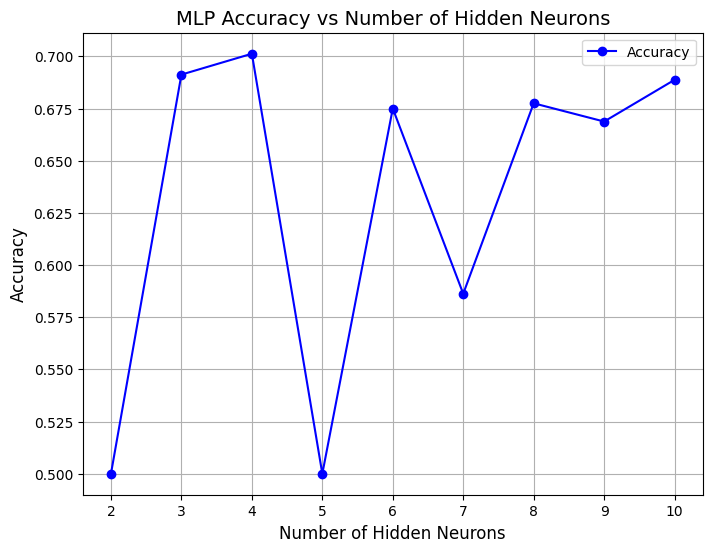

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Importando a bibliotecas necessárias
import matplotlib.pyplot as plt
from google.colab import files

# Plotando os resultados
plt.figure(figsize=(8, 6))
plt.plot(neurons_range, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('MLP Accuracy vs Number of Hidden Neurons', fontsize=14)
plt.xlabel('Number of Hidden Neurons', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(neurons_range)
plt.grid(True)
plt.legend()

# Salvando o gráfico
plt.savefig('mlp_accuracy_vs_neurons.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('mlp_accuracy_vs_neurons.png')